# 句子相似度匹配

## 1.问题理解（问题定义）

Quora Querstion Pairs数据集是Quora于2017年公开的句子匹配数据集，其通过给定两个句子的一致性标签标注，从而来判断句子是否一致。

- 数据集下载地址：https://www.kaggle.com/c/quora-question-pairs/data。
- GoogleNews-vectors-negative300.bin下载地址：https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz。


**变量命名：**

- 训练数据：kaggle提供train.csv数据集，在notebook中加载，并命名为data。
- 测试数据：kaggle提供的test.csv数据集
- 训 练 集：完成特征工程的数据集的80%，用于训练模型。（x_train, y_train）
- 验 证 集：完成特征工程的数据集的20%，用于验证模型。（x_val, y_val）


## 2.数据准备

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [139]:
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 导入所需包
import numpy as np
import time
import pandas as pd
import sklearn

In [3]:
# 解决matplotlib显示中文问题
# 仅适用于Windows
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [4]:
# 读取数据
# data = pd.read_table('./quora-dataset/quora_duplicate_questions.tsv')
sample_submission_data = pd.read_csv('./quora-dataset/sample_submission.csv')
train_data = pd.read_csv('./quora-dataset/train.csv')
test_data = pd.read_csv('./quora-dataset/test.csv')

In [5]:
train_data.shape

(404290, 6)

## 3.EDA

### 3.1 数据集描述

#### 3.1.1 sample_submission数据集

In [127]:
sample_submission_data.shape

(2345796, 2)

In [128]:
sample_submission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 2 columns):
test_id         int64
is_duplicate    int64
dtypes: int64(2)
memory usage: 35.8 MB


In [129]:
sample_submission_data.head(2)

,test_id,is_duplicate
0,0,1
1,1,1


#### 3.1.2 train数据集

In [130]:
train_data.shape

(404287, 6)

In [131]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [132]:
train_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [133]:
# 训练集中，question1和question2含义不同的观测数量
number_is_duplicate_negative = train_data.loc[train_data['is_duplicate'] == 0].shape[0]
print("训练集中，question1和question2含义不同（不重复）的观测数量:{}" .format(number_is_duplicate_negative))
print("训练集中，question1和question2含义相同（重复）的观测数量:{}" .format(train_data.shape[0]-number_is_duplicate_negative))

训练集中，question1和question2含义不同（不重复）的观测数量:255024
训练集中，question1和question2含义相同（重复）的观测数量:149263


#### 3.1.3 test数据集

In [134]:
test_data.shape

(3563475, 3)

In [135]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563475 entries, 0 to 3563474
Data columns (total 3 columns):
test_id      object
question1    object
question2    object
dtypes: object(3)
memory usage: 81.6+ MB


In [137]:
test_data.head(2)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?


#### 3.1.4 train和test数据集size区别

In [141]:
pal = sns.color_palette()
for f in os.listdir('./quora-dataset'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./quora-dataset/' + f) / 1000000, 2)) + 'MB')

test.csv                      477.59MB
train.csv                     63.4MB
quora_duplicate_questions.tsv 58.18MB
sample_submission.csv         22.35MB


### 3.2 数据集可视化

In [144]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rc('font',family='Microsoft YaHei') # 解决中文乱码或者不显示的问题

#### 3.2.1 train数据集问题对重复与不重复分布

/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:13

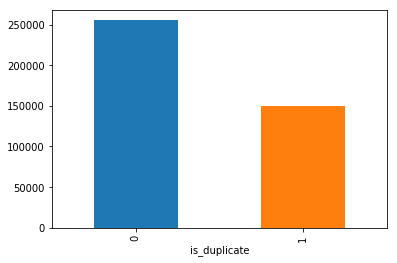

In [142]:
# 分布
# 内嵌绘图，这是ipython的魔法函数
%matplotlib inline
train_data.groupby("is_duplicate")['id'].count().plot.bar()
#plt.show() # 有了%matplotlib inline 就可以省掉plt.show()了

#### 3.2.2 train数据集句子出现频次

训练数据中的问题总数: 537929
出现多次的问题的数量: 111778



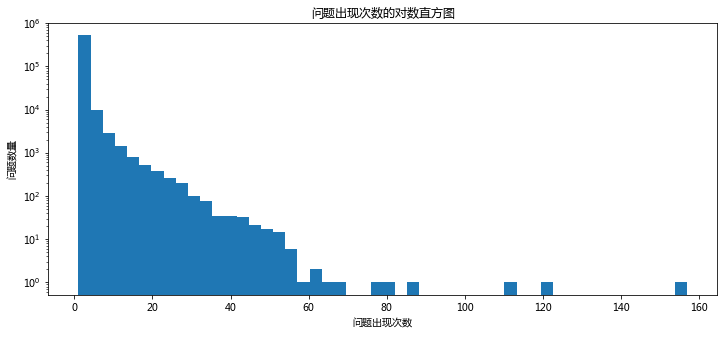

In [145]:
qids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
print('训练数据中的问题总数: {}'.format(len(np.unique(qids))))
print('出现多次的问题的数量: {}'.format(np.sum(qids.value_counts() > 1)))
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('问题出现次数的对数直方图')
plt.xlabel('问题出现次数')
plt.ylabel('问题数量')
print()

#### 3.2.3 train数据集，问题中单词的分布情况

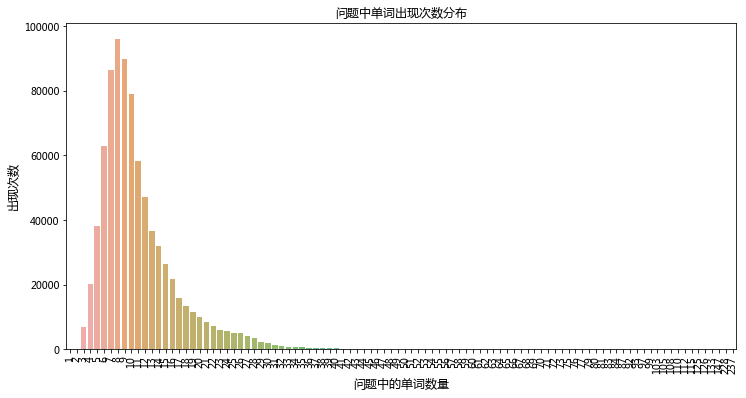

In [148]:
all_ques_df = pd.DataFrame(pd.concat([train_data['question1'], train_data['question2']]))
all_ques_df.columns = ["questions"]
all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.title('问题中单词出现次数分布')
plt.ylabel('出现次数', fontsize=12)
plt.xlabel('问题中的单词数量', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### 3.2.4 问题出现频率与问题对相同部分和是否重复之间的关系（构造q1->q2）

In [149]:
train_df = train_data
test_df = test_data

In [150]:
from collections import defaultdict
q_dict = defaultdict(set)
ques = pd.concat([train_df[['question1', 'question2']],
                  test_df[['question1', 'question2']]], axis=0).reset_index(drop='index')

for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])

def q1_freq(row):
    return(len(q_dict[row['question1']]))
    
def q2_freq(row):
    return(len(q_dict[row['question2']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect, axis=1, raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

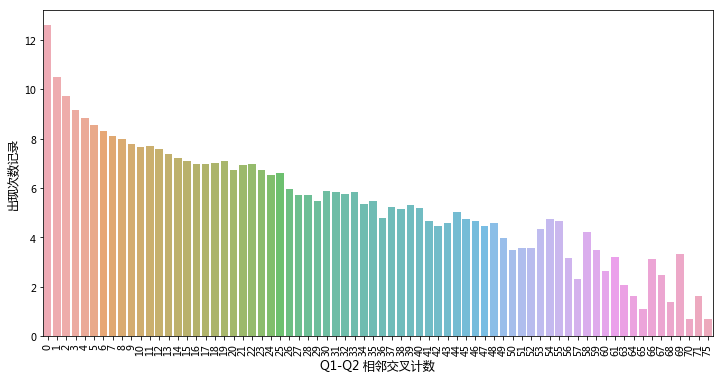

In [208]:
# Q1-Q2 neighbor intersection count
cnt_srs = train_df['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, np.log1p(cnt_srs.values), alpha=0.8)
plt.xlabel('Q1-Q2 相邻交叉计数', fontsize=12)
plt.ylabel('出现次数记录', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

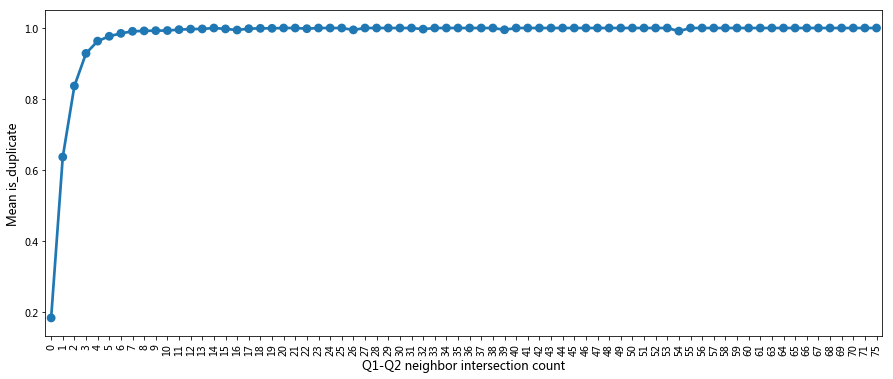

In [207]:
grouped_df = train_df.groupby('q1_q2_intersect')['is_duplicate'].aggregate(np.mean).reset_index()
plt.figure(figsize=(15,6))
sns.pointplot(grouped_df["q1_q2_intersect"].values, grouped_df["is_duplicate"].values, alpha=0.8)
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1-Q2相邻交叉部分计数', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

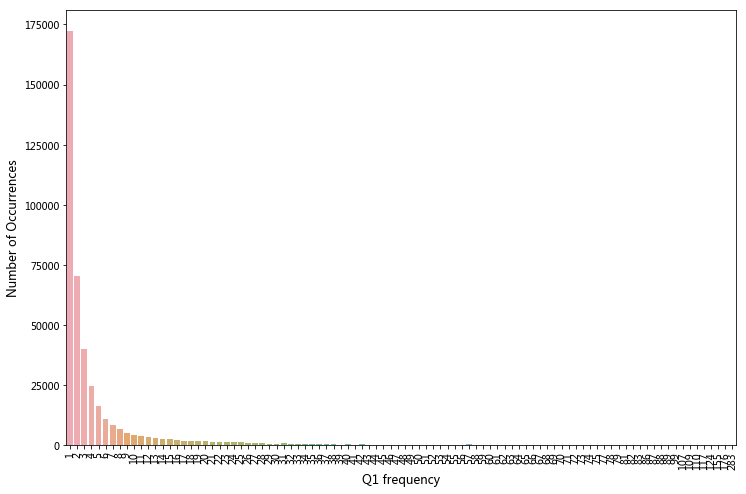

In [152]:
#Question1 Frequency
cnt_srs = train_df['q1_freq'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Q1 frequency', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

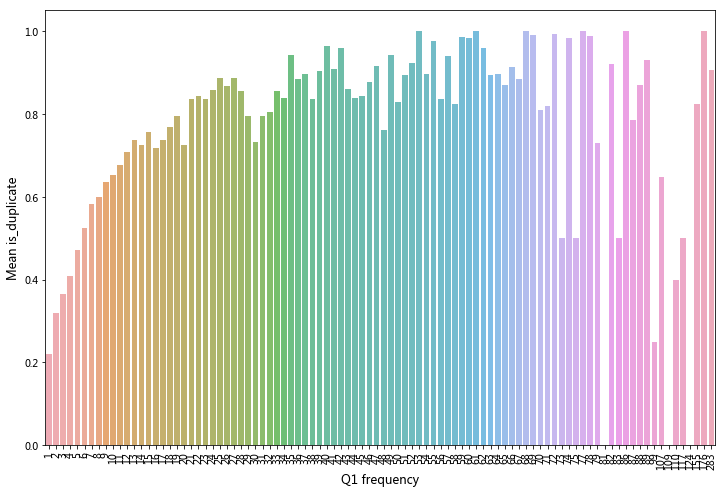

In [154]:
#Question1 Frequency and the target variable distribution
plt.figure(figsize=(12,8))
grouped_df = train_df.groupby('q1_freq')['is_duplicate'].aggregate(np.mean).reset_index()
sns.barplot(grouped_df["q1_freq"].values, grouped_df["is_duplicate"].values, alpha=0.8)
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1 frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

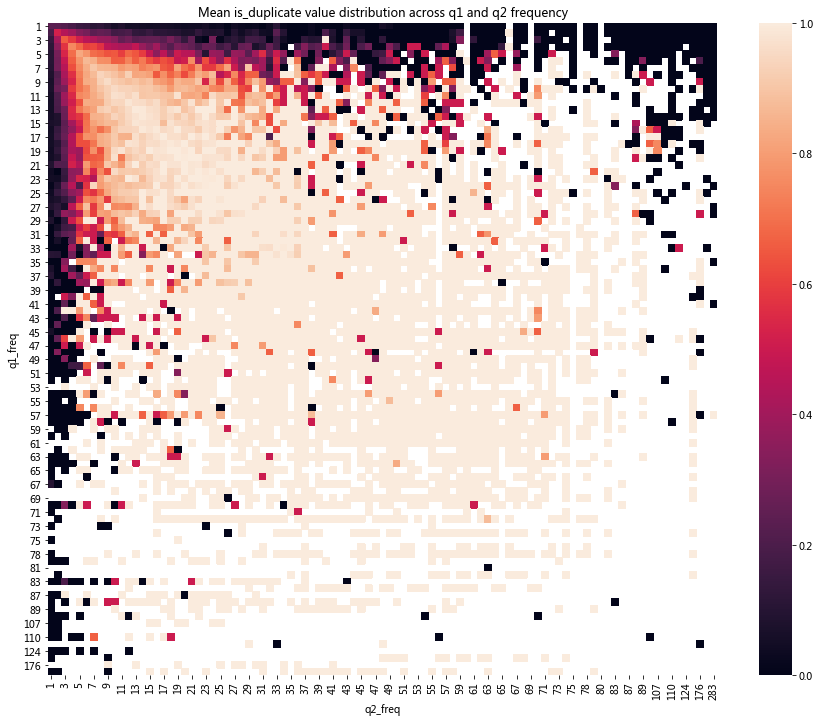

In [158]:
#heat map between q1_freq and q2_freq to see the target variable distribution
pvt_df = train_df.pivot_table(index="q1_freq", columns="q2_freq", values="is_duplicate")
plt.figure(figsize=(15,12))
sns.heatmap(pvt_df)
plt.title("Mean is_duplicate value distribution across q1 and q2 frequency")
plt.show()

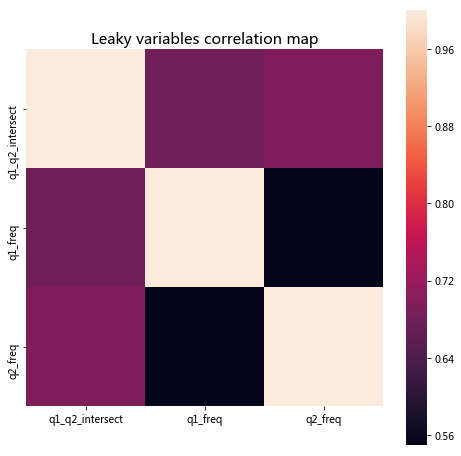

In [156]:
#check the correlation between the q1_freq、q2_freq and q1_q2_intersect
cols_to_use = ['q1_q2_intersect', 'q1_freq', 'q2_freq']
temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Leaky variables correlation map", fontsize=15)
plt.show()

#### 3.2.5 训练集、测试集的字符和词表

训练集、测试集各自的词表大小，以及测试集里面的未在训练集里面出现过的词的比例是多少；

/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


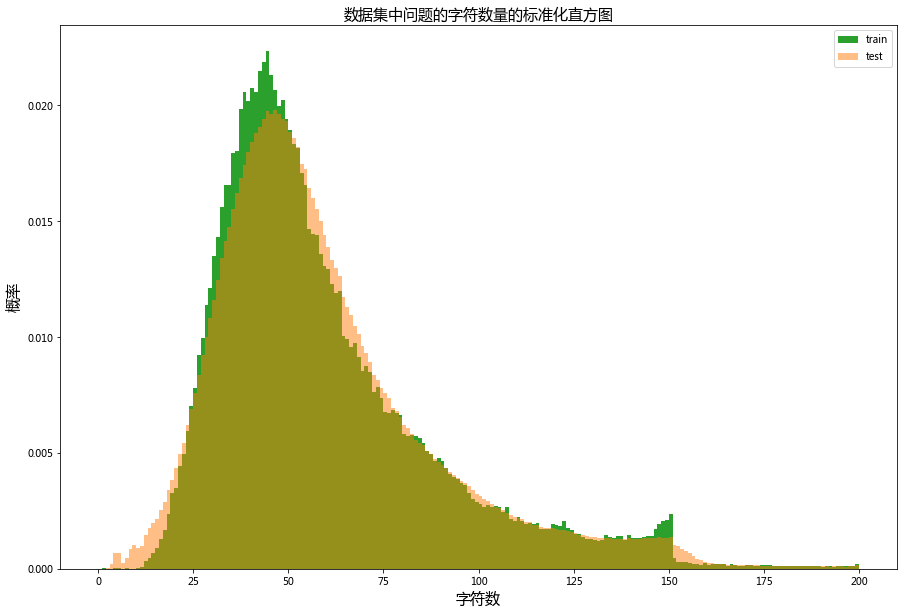

In [160]:
train_qs = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
test_qs = pd.Series(test_data['question1'].tolist() + test_data['question2'].tolist()).astype(str)

# 训练集和测试集字符数量特征
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('数据集中问题的字符数量的标准化直方图', fontsize=15)
plt.legend()
plt.xlabel('字符数', fontsize=15)
plt.ylabel('概率', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'\
      .format(dist_train.mean(),dist_train.std(),dist_test.mean(),dist_test.std(),dist_train.max(), dist_test.max()))

/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/liukaiyue/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


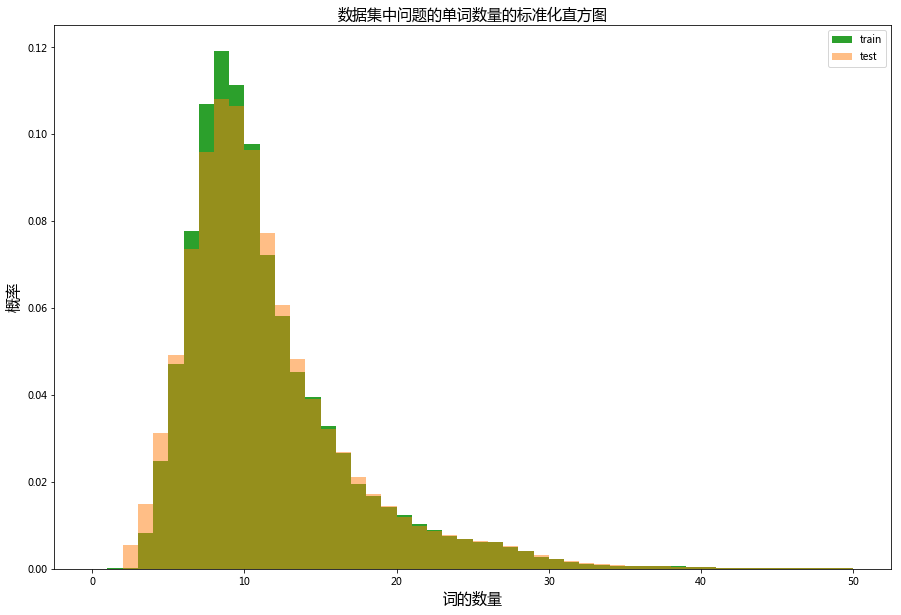

In [161]:
# 训练集和测试集单词数量特征（词表特征）
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('数据集中问题的单词数量的标准化直方图', fontsize=15)
plt.legend()
plt.xlabel('词的数量', fontsize=15)
plt.ylabel('概率', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'\
      .format(dist_train.mean(),dist_train.std(),dist_test.mean(),dist_test.std(),dist_train.max(),dist_test.max()))

In [186]:
print("训练集的词表大小:{}" .format(dist_train.sum()))
print("测试集的词表大小:{}" .format(dist_test.sum()))

训练集的词表大小:8946784
测试集的词表大小:78568963


## 4. 数据预处理

本节产生的数据仅做展示和测试使用，数据清洗和特征工程会在第5节一起操作和执行

#### 4.1 缺失值处理

In [372]:
# 去除空值（如果有的话）
cln_data = train_data.dropna().copy()

#### 4.2 全部变成小写

In [373]:
cln_data['question1'] = cln_data['question1'].str.lower()
cln_data['question2'] = cln_data['question2'].str.lower()

In [374]:
cln_data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0


#### 4.3 去掉标点符号

In [375]:
import string

In [376]:
def remove_punctuation(s):
    # 去除标点符号
    punctuation = set(string.punctuation)
    out = ''.join(ch for ch in s if ch not in punctuation)
    return out

In [377]:
# 去除标点符号
cln_data['question1'] = cln_data.apply(lambda x: remove_punctuation(x['question1'],), axis=1)
cln_data['question2'] = cln_data.apply(lambda x: remove_punctuation(x['question1'],), axis=1)

#### 4.4 分词处理

使用nltk的tokenize进行分词处理

In [378]:
import nltk
from nltk import word_tokenize

In [379]:
def spilt_word(s):
    #words = str(s).lower().decode('utf-8')
    words = word_tokenize(s)
    return words

In [380]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/liukaiyue/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [381]:
# 对question1进行分词处理，并赋值到新列
cln_data['question1_spilt'] = cln_data.apply(lambda x: spilt_word(x['question1'],), axis=1)

In [382]:
# 对question1进行分词处理，并赋值到新列
cln_data['question2_spilt'] = cln_data.apply(lambda x: spilt_word(x['question2'],), axis=1)

In [383]:
cln_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,question1_spilt,question2_spilt
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,what is the story of kohinoor kohinoor diamond,what is the story of kohinoor kohinoor diamond,0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, is, the, story, of, kohinoor, kohinoor,..."


#### 4.5 去除停用词

In [384]:
# 英语停用词，停用词是用来去除的，因为停用词在NLP时没有实际意义
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # 加载停用词
print("停用词的个数{}".format(len(stop_words)))
print("显示停用词{}".format(stop_words))

停用词的个数179
显示停用词['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

In [385]:
# 文本预处理函数
def preprocess_text(q):
    stop_words = stopwords.words('english')
    pre_q = [w for w in q if w not in stop_words]
    return pre_q

In [386]:
# 去除停用词，并赋值到新列
cln_data['question1_remove_swords'] = cln_data.apply(lambda x: preprocess_text(x['question1_spilt'],), axis=1)

In [387]:
# 去除停用词，并赋值到新列
cln_data['question2_remove_swords'] = cln_data.apply(lambda x: preprocess_text(x['question2_spilt'],), axis=1)

In [388]:
cln_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,question1_spilt,question2_spilt,question1_remove_swords,question2_remove_swords
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market, india]"
1,1,3,4,what is the story of kohinoor kohinoor diamond,what is the story of kohinoor kohinoor diamond,0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, is, the, story, of, kohinoor, kohinoor,...","[story, kohinoor, kohinoor, diamond]","[story, kohinoor, kohinoor, diamond]"


## 5. 特征工程

实际上特征工程也是在准备数据集，只是在原有数据集上进行加工了。原数据是文本数据不能作为训练模型的数据，因此必须通过特征工程提取特征，成为可以训练的定量数据

In [6]:
# 数据准备，将cln_data数据集，该名称为data
# data = cln_data
data = train_data.dropna().copy()

In [7]:
data.shape

(404287, 6)

### 5.1 基础特征工程（f1）

In [8]:
# feature1：Length of question1
data['len_q1'] = data.question1.apply(lambda x: len(str(x)))
# feature2：Length of question2
data['len_q2'] = data.question2.apply(lambda x: len(str(x)))
# feature3：Difference in the two lengths
data['diff_len'] = data.len_q1 - data.len_q2
# feature4：Character length of question1 without spaces
data['len_char_q1'] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# feature5：Character length of question2 without spaces
data['len_char_q2'] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# feature6：Number of words in question1
data['q1_n_words'] = data.question1.apply(lambda x: len(str(x).split()))
# feature7：Number of words in question2
data['q2_n_words'] = data.question2.apply(lambda x: len(str(x).split()))
# feature8
data['q_n_words_avg'] = np.round((data['q1_n_words'] + data['q2_n_words'])/2.0).astype(int)
# feature9：Number of common words in question1 and question2
data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [9]:
# feature10(需要去除缺失值)
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
# 写入特征
data['word_share'] = data.apply(normalized_word_share, axis=1)

In [10]:
f1 = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'q1_n_words', 'q2_n_words', 'q_n_words_avg', 'common_words', 'word_share']

In [11]:
data.shape, data[f1].shape

((404287, 16), (404287, 10))

### 5.2 fuzzy特征（f2）

In [83]:
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

In [84]:
start_time_fuzz_qratio = time.time()
# feature
data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_qratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_qratio-start_time_fuzz_qratio))

程序运行时间137.25356602668762秒


In [85]:
start_time_fuzz_WRatio = time.time()
# feature
data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_WRatio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_WRatio-start_time_fuzz_WRatio))

程序运行时间1118.1576180458069秒


In [86]:
start_time_fuzz_partial_ratio = time.time()
# feature
data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_partial_ratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_partial_ratio-start_time_fuzz_partial_ratio))

程序运行时间867.0104179382324秒


In [87]:
start_time_fuzz_partial_token_set_ratio = time.time()
# feature
data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_partial_token_set_ratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_partial_token_set_ratio-start_time_fuzz_partial_token_set_ratio))

程序运行时间881.5385100841522秒


In [88]:
start_time_fuzz_partial_token_sort_ratio = time.time()
# feature
data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_partial_token_sort_ratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_partial_token_sort_ratio-start_time_fuzz_partial_token_sort_ratio))

程序运行时间986.1695880889893秒


In [89]:
start_time_fuzz_token_set_ratio = time.time()
# feature
data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_token_set_ratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_token_set_ratio-start_time_fuzz_token_set_ratio))

程序运行时间192.46035599708557秒


In [90]:
start_time_fuzz_token_sort_ratio = time.time()
# feature
data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
end_time_fuzz_token_sort_ratio = time.time()
print("程序运行时间{}秒".format(end_time_fuzz_token_sort_ratio-start_time_fuzz_token_sort_ratio))

程序运行时间140.31804633140564秒


In [91]:
f2 = ['fuzz_qratio','fuzz_WRatio','fuzz_partial_ratio','fuzz_partial_token_set_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio']

### 5.3 TF-IDF和SVD特征（F3）

##### 5.3.1 执行TF-IDF

In [74]:
# ID-IDF,SVD特征FS3
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import deepcopy
tfv_q1 = TfidfVectorizer(min_df=3,
                         max_features=None, 
                         strip_accents='unicode', 
                         analyzer='word', 
                         token_pattern=r'w{1,}', 
                         ngram_range=(1, 2), 
                         use_idf=1, smooth_idf=1, 
                         sublinear_tf=1, 
                         stop_words='english')
tfv_q2 = deepcopy(tfv_q1)
q1_tfidf = tfv_q1.fit_transform(data.question1.fillna(""))
q2_tfidf = tfv_q2.fit_transform(data.question2.fillna(""))

##### 5.3.2执行SVD

About n_components Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.

In [75]:
# 创建SVD特征(我们选择了2个分量进行SVD分解，这些特征在TF-IDF矩阵上进行计算)
from sklearn.decomposition import TruncatedSVD
svd_q1 = TruncatedSVD(n_components=2, random_state=42)
svd_q2 = TruncatedSVD(n_components=2, random_state=42)
question1_vectors = svd_q1.fit_transform(q1_tfidf)
question2_vectors = svd_q2.fit_transform(q2_tfidf)

##### 5.3.3 F3_1

In [76]:
# F3_1特征（qustion1和question2分别进行TF-IDF，再形成model）
from scipy import sparse
# obtain features by stacking the sparse matrices together
f3_1 = sparse.hstack((q1_tfidf, q2_tfidf))


##### 5.3.4 F3_2

In [77]:
# F3_2特征（qustion1和question2合并进行TF-IDF形成model）
tfv = TfidfVectorizer(min_df=3, 
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word', 
                      token_pattern=r'w{1,}',
                      ngram_range=(1, 2), 
                      use_idf=1, 
                      smooth_idf=1, 
                      sublinear_tf=1,
                      stop_words='english')
# combine questions and calculate tf-idf
q1q2 = data.question1.fillna("") 
q1q2 += " " + data.question2.fillna("")
f3_2 = tfv.fit_transform(q1q2)


##### 5.3.5 F3_3

In [78]:
# FS3_3特征（qustion1和question2分别进行TF-IDF和SVD，再形成model）
# obtain features by stacking the matrices together
f3_3 = np.hstack((question1_vectors, question2_vectors))

##### 5.3.6 F3_4

In [79]:
svd_q1q2 = TruncatedSVD(n_components=3)
f3_4 = svd_q1q2.fit_transform(f3_1)

##### 5.3.7 F3_5

In [80]:
f3_5 = svd_q1.fit_transform(f3_2)

In [81]:
data.shape

(404287, 35)

### 5.4 距离特征（F4_1）

In [39]:
import nltk
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
# 英语停用词，停用词是用来去除的，因为停用词在NLP时没有实际意义
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # 加载停用词

In [42]:
start_time_sent2vec = time.time()
# # F4特征 Word2vec =========
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

question1_vectors = np.zeros((data.shape[0], 300))
error_count = 0
for i, q in tqdm(enumerate(data.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((data.shape[0], 300))
for i, q in tqdm(enumerate(data.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
end_time_sent2vec = time.time()
print("程序运行时间{}秒".format(end_time_sent2vec-start_time_sent2vec))

404287it [02:03, 3280.88it/s]
404287it [01:40, 4025.54it/s]


程序运行时间609.6521821022034秒


In [43]:
f4_1 = ['cosine_distance', 'cityblock_distance', 'jaccard_distance', 'canberra_distance', 'euclidean_distance', 'minkowski_distance','braycurtis_distance']

### 5.4 wmd特征（F4_2）

#### 5.4.1 wmd

In [58]:
import gensim

In [59]:
# =========
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

model = gensim.models.KeyedVectors.load_word2vec_format('./词向量_for_toxic/GoogleNews-vectors-negative300.bin.gz', binary=True)
data['wmd'] = data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


#### 5.4.2 norm_wmd

In [60]:
# =========
def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)

norm_model = gensim.models.KeyedVectors.load_word2vec_format('./词向量_for_toxic/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
data['norm_wmd'] = data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)


In [61]:
f4_2 = ['wmd', 'norm_wmd']

### 5.5 散列特征（F5）

在原来代码的基础上删掉test部分，只留下train部分

In [25]:
train_data = train_data.dropna().copy()

In [26]:
df1 = train_data[['question1']].copy()  # df1赋值，是训练集的question1列
df2 = train_data[['question2']].copy()  # df2赋值，是训练集的question2列
df1_test = test_data[['question1']].copy()  # df1_test赋值，是训练集的question1列
df2_test = test_data[['question2']].copy()  # df2_test赋值，是训练集的question2列
df2.rename(columns = {'question2':'question1'},inplace=True)  # 将df2列名修改为question1
df2_test.rename(columns = {'question2':'question1'},inplace=True)  # 将df2_test列名修改为question1
train_questions = df1.append(df2)  # train_questions是df1+df2(这也解释了前面为什么修改列名)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)  # 构造出一个全新的问题集，将训练集和测试集的所有问题全部追加成成一列
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)  # drop_duplicates去除question列的重复
train_questions.reset_index(inplace=True,drop=True) # reset_index去除question列的重复
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
# questions_dict是构造好的能够被映射的dict字典
train_cp = train_data.copy()
test_cp = test_data.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)
test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
train_cp['q1_hash'] = train_cp['question1'].map(questions_dict)
train_cp['q2_hash'] = train_cp['question2'].map(questions_dict)

In [27]:
q1_vc = train_cp.q1_hash.value_counts().to_dict()
q2_vc = train_cp.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
train_cp['q1_freq'] = train_cp['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
train_cp['q2_freq'] = train_cp['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

In [28]:
data['q1_hash'] = train_cp['q1_hash']
data['q2_hash'] = train_cp['q2_hash']
data['q1_freq'] = train_cp['q1_freq']
data['q2_freq'] = train_cp['q2_freq']

In [29]:
f5 = ['q1_hash', 'q2_hash', 'q1_freq', 'q2_freq']

In [30]:
data.shape

(404287, 22)

### 5.6 word_match特征（f6）

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
df_train = train_data.dropna().copy()

##### 5.6.1 word_match特征

In [13]:
# First we create our training and testing data
x_train = pd.DataFrame()
# 特征word_match
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
x_train['word_match'] = train_word_match

##### 5.6.2 tfidf_word_match特征

In [14]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
# 特征tfidf_word_match
from collections import Counter
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
x_train['tfidf_word_match'] = tfidf_train_word_match

In [15]:
data['word_match'] = x_train['word_match']
data['tfidf_word_match'] = x_train['tfidf_word_match']

In [16]:
f6 = ['word_match','tfidf_word_match']

In [17]:
data.shape, data[f6].shape

((404287, 18), (404287, 2))

### 5.7 特征q1_q2_intersect（f7）

In [99]:
# f7特征q1_q2_intersect
ques = pd.concat([train_data[['question1', 'question2']],test_data[['question1', 'question2']]], axis=0).reset_index(drop='index')
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])

def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

data['q1_q2_intersect'] = train_data.apply(q1_q2_intersect, axis=1, raw=True)

In [100]:
f7 = ['q1_q2_intersect']

### 5.8 特征（f8）

In [247]:
from collections import defaultdict
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
# 加载数据
train_orig =  train_data
test_orig =  test_data
question = pd.concat([train_orig[['question1', 'question2']],test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')

def word_match_share(q1, q2, stops=None):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1words = {}
    q2words = {}
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0.
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

q_dict = defaultdict(dict)
for i in range(question.shape[0]):
    wm = word_match_share(question.question1[i], question.question2[i], stops=stops)
    q_dict[question.question1[i]][question.question2[i]] = wm
    q_dict[question.question2[i]][question.question1[i]] = wm

# def q1_q2_intersect(row):
#     return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))
def q1_q2_wm_ratio(row):
    q1 = q_dict[row['question1']]
    q2 = q_dict[row['question2']]
    inter_keys = set(q1.keys()).intersection(set(q2.keys()))
    if(len(inter_keys) == 0): return 0.
    inter_wm = 0.
    total_wm = 0.
    for q,wm in q1.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    for q,wm in q2.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    if(total_wm == 0.): return 0.
    return inter_wm/total_wm

train_orig['q1_q2_wm_ratio'] = train_orig.apply(q1_q2_wm_ratio, axis=1, raw=True)

In [251]:
data['q1_q2_wm_ratio'] = train_orig['q1_q2_wm_ratio']

In [271]:
f8 = ['q1_q2_wm_ratio']

### 5.9 特征（f9）

In [263]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
df = train_data.fillna("")

edges = [tuple(x) for x in df[['question1', 'question2']].values]
G.add_edges_from(edges)

map_label = dict(((x[0], x[1]), x[2]) for x in df[['question1', 'question2', 'is_duplicate']].values)
map_clique_size = {}
cliques = sorted(list(nx.find_cliques(G)), key=lambda x: len(x))
for cli in cliques:
    for q1, q2 in combinations(cli, 2):
        if (q1, q2) in map_label:
            map_clique_size[q1, q2] = len(cli)
        elif (q2, q1) in map_label:
            map_clique_size[q2, q1] = len(cli)
df['clique_size'] = df.apply(lambda row: map_clique_size.get((row['question1'], row['question2']), -1), axis=1)

In [269]:
data['clique_size'] = df['clique_size']

In [272]:
f9 = ['clique_size']

### 5.10 特征（f10）

In [284]:
train_data = train_data.drop(['q1_q2_intersect', 'q1_freq', 'q2_freq', 'q1_q2_wm_ratio'], axis=1)

In [285]:
import pandas as pd               
df_train10 = train_data.fillna("")

#Generating a graph of Questions and their neighbors
def generate_qid_graph_table(row):
    hash_key1 = row["qid1"]
    hash_key2 = row["qid2"]
    # Python 字典 setdefault()函数和get()方法类似, 如果键不存在于字典中，将会添加键并将值设为默认值。   
    qid_graph.setdefault(hash_key1, []).append(hash_key2)
    qid_graph.setdefault(hash_key2, []).append(hash_key1)

qid_graph = {}
df_train10.apply(generate_qid_graph_table, axis = 1)

def pagerank():
    MAX_ITER = 20 # 迭代次数
    d = 0.85
    # 初始化：使每个节点都有一个统一的值
    pagerank_dict = {i:1/len(qid_graph) for i in qid_graph}
    num_nodes = len(pagerank_dict)    
    for iter in range(0, MAX_ITER):        
        for node in qid_graph:    
            local_pr = 0           
            for neighbor in qid_graph[node]:
                local_pr += pagerank_dict[neighbor]/len(qid_graph[neighbor])
            pagerank_dict[node] = (1-d)/num_nodes + d*local_pr
    return pagerank_dict

pagerank_dict = pagerank()

def get_pagerank_value(row):
    return pd.Series({
        "q1_pr": pagerank_dict[row["qid1"]],
        "q2_pr": pagerank_dict[row["qid2"]]
    })

pagerank_feats_train = df_train10.apply(get_pagerank_value, axis = 1);

In [289]:
data['q1_pr'] = pagerank_feats_train['q1_pr']
data['q2_pr'] = pagerank_feats_train['q2_pr']

In [290]:
f10 = ['q1_pr', 'q2_pr']

### 5.10 存储特征工程

In [108]:
# 将完成的特征写入新的CSV文件存储
import csv
data.to_csv('./features_file/quora_features.csv', index=False)
data.head(2)  # 查看存储是否成功，如成功则打印出前三行数据

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,...,wmd,norm_wmd,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_q2_intersect
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,...,0.564615,0.217555,93,95,98,100,88,100,93,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,...,3.772346,1.368796,66,86,73,100,73,86,63,0


## 6. logistic回归

### 6.1 构造训练集和验证集

In [109]:
# 导入包和机器学习模型
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [110]:
# 构建测试数据
scaler = StandardScaler()
y = data.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = data[f1+f2+f4_1+f4_2+f5]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, f3_3))
X = np.hstack((X, f3_4))
X = np.hstack((X, f3_5))
# 我们还选择了训练数据用于通过滤波该第一F1，F2，F4_1，和F4_2设置的变量，并且随后堆叠这些F3_3稀疏矩阵SVD数据。

In [111]:
# 准备训练数据集合验证数据集
# 我们还提供随机裂片分离1/10的数据用于验证目的(为了有效评估产生的模型)：
np.random.seed(42)
n_all, _ = y.shape
idx = np.arange(n_all)
np.random.shuffle(idx)
n_split = n_all // 10
idx_val = idx[:n_split]
idx_train = idx[n_split:]
# 构造训练集验证集
x_train_set = X[idx_train]  # 训练数据特征
y_train_set = np.ravel(y[idx_train]) # 训练数据标签
x_val_set = X[idx_val]  # 验证数据特征
y_val_set = np.ravel(y[idx_val])  # 验证数据标签

In [112]:
x_train_set.shape, y_train_set.shape, x_val_set.shape, y_val_set.shape

((363859, 39), (363859,), (40428, 39), (40428,))

### 6.2 logistic回归模型训练

In [114]:
# 训练模型
# 作为第一模型，逻辑回归、L2正则化参数设定为0.1C(适度调整)。一旦模型已就绪，我们测试其功效的验证集(X_VAL培训矩阵，Y_VAL)为正确答案。
# 对结果进行评估的精度，是精确比例的猜测对验证集合：
# 执行logistic回归模型
logres = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=1000)
logres.fit(x_train_set, y_train_set)
lr_preds = logres.predict(x_val_set)
log_res_accuracy = np.sum(lr_preds == y_val_set) / len(y_val_set)
print("Logistic regr accuracy: %0.3f" % log_res_accuracy)

Logistic regr accuracy: 0.754


In [115]:
# 查看logloss
from sklearn.metrics import log_loss
y_pred_logistic_log = logres.predict_proba(x_val_set)
score_logistic = log_loss(y_val_set, y_pred_logistic_log)
print("对数损失函数值：",score_logistic)

对数损失函数值： 0.462675968762


### 6.3 随机森林

In [209]:
from sklearn.ensemble import RandomForestClassifier
model_randomforest = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
model_randomforest.fit(x_train_set, y_train_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [210]:
from sklearn.metrics import accuracy_score
y_val_pres = model_randomforest.predict(x_val_set)
print('准确率：', accuracy_score(y_val_set, y_val_pres))

准确率： 0.847630355199


In [212]:
# from sklearn.metrics import log_loss
y_val_pre = model_randomforest.predict_proba(x_val_set)

score_logistic = log_loss(y_val_set, y_val_pre)
print("对数损失函数值：",score_logistic)

对数损失函数值： 0.32563975926


## 7. XGboost

### 7.1 构造训练集和验证集

In [18]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_train['word_match'] = data['word_match']
x_train['tfidf_word_match'] = data['tfidf_word_match']
y_train = data['is_duplicate'].values

pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.1912434159697727


In [19]:
x_train[f1] = data[f1]

In [31]:
x_train[f5] = data[f5]

In [68]:
x_train[f4_1] = data[f4_1]

In [62]:
x_train[f4_2] = data[f4_2]

In [92]:
x_train[f2] = data[f2]

In [101]:
x_train[f7] = data[f7]

In [253]:
x_train[f8] = data[f8]

In [273]:
x_train[f9] = data[f9]

In [291]:
x_train[f10] = data[f10]

In [292]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [293]:
x_train.shape, x_valid.shape

((83802, 37), (20951, 37))

### 7.2 XGBoost

#### 7.2.1 XGBoost随机测试参数

In [338]:
import xgboost as xgb
params = {}
params = {'max_depth':4, 'eta':0.02, 'objective':'binary:logistic' }
params['eval_metric'] = 'logloss'
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_valid = xgb.DMatrix(x_valid) # 调参

[18:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.678647	valid-logloss:0.678678
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[18:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:15:37] src/

[18:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.286828	valid-logloss:0.287069
[18:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:15:55] src/tree/updater_prune.cc:74: tree pruning

[18:16:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:16:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.220586	valid-logloss:0.220915
[18:16:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:13] src/tree/updater_prune.cc:74: tree prunin

[18:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.203361	valid-logloss:0.20432
[18:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:31] src/tree/updater_prune.cc:74: tree pruning

[18:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[280]	train-logloss:0.195879	valid-logloss:0.197544
[18:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:16:48] src/tree/updater_prune.cc:74: tree prunin

[18:17:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[350]	train-logloss:0.191011	valid-logloss:0.193441
[18:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:06] src/tree/updater_prune.cc:74: tree prunin

In [339]:
xgb_preds = (bst.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_valid) / len(y_valid)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

Xgb accuracy: 0.925


In [340]:
# 计算logloss
from sklearn.metrics import log_loss
ans = bst.predict(d_valid)
score = log_loss(y_valid, ans)
print (score)

0.191257647193


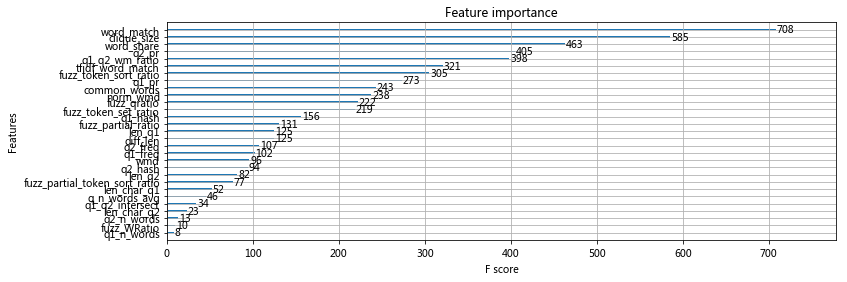

In [341]:
# 显示重要特征
from xgboost import plot_importance
plot_importance(bst)
plt.show()

##### 7.2.2 XGBoost模型max_depth和learning_rate参数调优

In [299]:
# 1. 导入 GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier  # 导入XGBmodel分类器 

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [302]:
# 2.选择参数：(逻辑回归的参数)
# 现在选择想要选择的参数，并形成一个字典。 在这本字典中，键 (keys) 将是参数的名称，值 （values) 将是每个参数可能值的列表。
cv_params1 = {'max_depth':range(4,16,2),
             'learning_rate': [0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.7, 0.9]}  # 要调优的参数

In [303]:
# 3.创建一个评分机制 (scorer)。需要确认将使用什么指标来为每个候选模型评分，使用 logloss 分数。
#4. 使用参数 (parameter) 和评分机制 (scorer) 创建一个 GridSearch 对象
# 参数初始化
other_params1 = {'objective':'binary:logistic', 'eval_metric':'logloss',
                'n_estimators':2,
                'silent':0, 
                'cv':5,
                'seed': 0,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'gamma': 0, 
                'min_child_weight':1,
                'reg_alpha': 0,
                'reg_lambda': 1}

In [304]:
#4. 使用参数 (parameter) 和评分机制 (scorer) 创建一个 GridSearch 对象
# Create the object.
clf_xgb1 = xgb.XGBClassifier(**other_params1)
grid_obj1 = GridSearchCV(estimator=clf_xgb1, 
                         param_grid=cv_params1, 
                         scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)

# Fit the data
grid_obj1.fit(x_train, y_train)  # 使用网格搜索训练模型，找到包含最佳参数的对象grid_fit

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:06:30] src/tree/updater_prune.cc:74: t

[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, ma

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.6s


[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 prun

[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=12
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 0 pruned nodes, max_depth=12
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=12
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=12
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=12
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 750 extra nodes, 0 pruned nodes, max_depth=12
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=12
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 p

[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1130 extra nodes, 0 pruned nodes, max_depth=14
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1052 extra nodes, 0 pruned nodes, max_depth=14
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=14
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 0 pruned nodes, max_depth=14
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1198 extra nodes, 0 pruned nodes, max_depth=14
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1030 extra nodes, 0 pruned nodes, max_depth=14
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 

[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max

[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min


[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 prun

[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=12
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1026 extra nodes, 0 pruned nodes, max_depth=12
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=12
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=12
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=12
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=12
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=12
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 

[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.1min finished


[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=10


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, cv=5, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=0,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': range(4, 16, 2), 'learning_rate': [0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [305]:
print('参数的最佳取值：{0}'.format(grid_obj1.best_params_))
print('最佳模型得分:{0}'.format(abs(grid_obj1.best_score_)))

参数的最佳取值：{'learning_rate': 0.9, 'max_depth': 10}
最佳模型得分:0.23104731961819383


##### 7.2.3 XGBoost模型n_estimators和min_child_weight参数调优

In [306]:
# 要调优参数
cv_params2 = {'n_estimators':range(1,12,2), 
              'min_child_weight':range(1,8,2)}  # 要调优的参数

In [307]:
# 参数初始化
other_params2 = {'objective':'binary:logistic', 'eval_metric':'logloss',
                 'max_depth':10,  # 已经调优
                 'learning_rate':0.9,  # 已经调优
                 'silent':0, 
                 'cv':5,
                 'seed': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'gamma': 0, 
                 'reg_alpha': 0,
                 'reg_lambda': 1}

In [308]:
# Create the object.
clf_xgb2 = xgb.XGBClassifier(**other_params2)
grid_obj2 = GridSearchCV(estimator=clf_xgb2, 
                         param_grid=cv_params2, 
                         scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)

# Fit the data
grid_obj2.fit(x_train, y_train)  # 使用网格搜索训练模型，找到包含最佳参数的对象grid_fit

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[16:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:25:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:25:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[16:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[16:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:25:23] src/tree/update

[16:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[16:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[16:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[16:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[16:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[16:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 p

[16:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[16:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[16:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[16:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[16:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[16:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 p

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.9s


[16:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[16:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[16:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[16:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[16:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 p

[16:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[16:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 p

[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 p

[16:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[16:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[16:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[16:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 p

[16:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[16:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 p

[16:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[16:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 p

[16:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:27:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[16:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 p

[16:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  2.6min finished


[16:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, cv=5, eval_metric='logloss', gamma=0,
       learning_rate=0.9, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=0,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(1, 12, 2), 'min_child_weight': range(1, 8, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [309]:
print('参数的最佳取值：{0}'.format(grid_obj2.best_params_))
print('最佳模型得分:{0}'.format(abs(grid_obj2.best_score_)))

参数的最佳取值：{'min_child_weight': 7, 'n_estimators': 5}
最佳模型得分:0.20034056311779624


##### 7.2.4 XGBoost模型gamma参数调优

In [310]:
# 要调优参数
cv_params3 = {'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}  # 要调优的参数

In [311]:
# 参数初始化
other_params3 = {'objective':'binary:logistic', 'eval_metric':'logloss',
                 'max_depth':10,  # 已经调优
                 'learning_rate':0.9,  # 已经调优
                 'min_child_weight':7,  # 已经调优
                 'n_estimators':5,  # 已经调优
                 'silent':0, 
                 'cv':5,
                 'seed': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'reg_alpha': 0,
                 'reg_lambda': 1}

In [312]:
# Create the object.
clf_xgb3 = xgb.XGBClassifier(**other_params3)
grid_obj3 = GridSearchCV(estimator=clf_xgb3, 
                         param_grid=cv_params3, 
                         scoring='neg_log_loss', 
                         cv=5, verbose=1, n_jobs=4)

# Fit the data
grid_obj3.fit(x_train, y_train)  # 使用网格搜索训练模型，找到包含最佳参数的对象grid_fit

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 4 pruned nodes, max_depth=10
[16:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 2 pruned nodes, max_depth=10
[16:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 2 pruned nodes, max_depth=10
[16:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 4 pruned nodes, max_depth=10
[16:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 2 pruned nodes, max_depth=10
[16:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 4 pruned nodes, max_depth=10
[16:31:01] src/tree/updater_

[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 2 pruned nodes, max_depth=10
[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 10 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 4 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 6 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 6 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 2 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 2 pruned nodes, max_depth=10
[16:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 2 pruned nodes, max_depth=10
[16:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 6 

[16:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 10 pruned nodes, max_depth=10
[16:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 16 pruned nodes, max_depth=10
[16:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 14 pruned nodes, max_depth=10
[16:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 10 pruned nodes, max_depth=10
[16:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 4 pruned nodes, max_depth=10
[16:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 8 pruned nodes, max_depth=10


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   33.8s finished


[16:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 8 pruned nodes, max_depth=10
[16:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 14 pruned nodes, max_depth=10
[16:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 14 pruned nodes, max_depth=10
[16:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=10
[16:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 4 pruned nodes, max_depth=10


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, cv=5, eval_metric='logloss', gamma=0,
       learning_rate=0.9, max_delta_step=0, max_depth=10,
       min_child_weight=7, missing=None, n_estimators=5, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=0,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [313]:
print('参数的最佳取值：{0}'.format(grid_obj3.best_params_))
print('最佳模型得分:{0}'.format(abs(grid_obj3.best_score_)))

参数的最佳取值：{'gamma': 0.4}
最佳模型得分:0.20021738085782625


##### 7.2.5 XGBoost模型subsample和colsample_bytree参数调优

In [314]:
# 要调优参数
cv_params4 = {'subsample':[0.6, 0.7, 0.8, 0.9], 
              'colsample_bytree':[0.6, 0.7, 0.8, 0.9]}  # 要调优的参数

In [315]:
# 参数初始化
other_params4 = {'objective':'binary:logistic', 'eval_metric':'logloss',
                 'max_depth':10,  # 已经调优
                 'learning_rate':0.9,  # 已经调优
                 'min_child_weight': 7,  # 已经调优
                 'n_estimators': 5,  # 已经调优
                 'gamma':0.4,  # 已经调优
                 'silent':0, 
                 'cv':5,
                 'seed': 0,
                 'reg_alpha': 0,
                 'reg_lambda': 1}

In [316]:
# Create the object.
clf_xgb4 = xgb.XGBClassifier(**other_params4)
grid_obj4 = GridSearchCV(estimator=clf_xgb4, 
                         param_grid=cv_params4, 
                         scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)

# Fit the data
grid_obj4.fit(x_train, y_train)  # 使用网格搜索训练模型，找到包含最佳参数的对象grid_fit

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[16:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 2 pruned nodes, max_depth=10
[16:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 2 pruned nodes, max_depth=10
[16:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 2 pruned nodes, max_depth=10
[16:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 12 pruned nodes, max_depth=10
[16:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 14 pruned nodes, max_depth=10
[16:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 4 pruned nodes, max_depth=10
[16:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 12 pruned nodes, max_depth=10
[16:33:18] src/tree/upda

[16:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 14 pruned nodes, max_depth=10
[16:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 2 pruned nodes, max_depth=10
[16:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 10 pruned nodes, max_depth=10
[16:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 8 pruned nodes, max_depth=10
[16:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 12 pruned nodes, max_depth=10
[16:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 4 pruned nodes, max_depth=10
[16:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 4 pruned nodes, max_depth=10
[16:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 2 pruned nodes, max_depth=10
[16:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 

[16:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=10
[16:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 18 pruned nodes, max_depth=10
[16:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 10 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 12 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 10 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 4 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 10 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 8 pruned nodes, max_depth=10
[16:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes

[16:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 2 pruned nodes, max_depth=10
[16:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 4 pruned nodes, max_depth=10
[16:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 2 pruned nodes, max_depth=10


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.8s


[16:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 2 pruned nodes, max_depth=10
[16:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 4 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 8 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 8 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 18 pruned nodes, max_depth=10
[16:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 4 pruned nodes, max_depth=10
[16:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 16

[16:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 pruned nodes, max_depth=10
[16:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 8 pruned nodes, max_depth=10
[16:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 8 pruned nodes, max_depth=10
[16:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 16 pruned nodes, max_depth=10
[16:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 4 pruned nodes, max_depth=10
[16:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 4 pruned nodes, max_depth=10
[16:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 2 pruned nodes, max_depth=10
[16:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 4 pruned nodes, max_depth=10
[16:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 4 

[16:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 6 pruned nodes, max_depth=10
[16:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 10 pruned nodes, max_depth=10
[16:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 4 pruned nodes, max_depth=10
[16:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 10 pruned nodes, max_depth=10
[16:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 4 pruned nodes, max_depth=10
[16:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 14 pruned nodes, max_depth=10
[16:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 14 pruned nodes, max_depth=10
[16:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes,

[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.4min finished


[16:34:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 4 pruned nodes, max_depth=10
[16:34:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 10 pruned nodes, max_depth=10
[16:34:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 6 pruned nodes, max_depth=10
[16:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 6 pruned nodes, max_depth=10
[16:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 8 pruned nodes, max_depth=10


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, cv=5, eval_metric='logloss', gamma=0.4,
       learning_rate=0.9, max_delta_step=0, max_depth=10,
       min_child_weight=7, missing=None, n_estimators=5, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=0,
       subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [317]:
print('参数的最佳取值：{0}'.format(grid_obj4.best_params_))
print('最佳模型得分:{0}'.format(abs(grid_obj4.best_score_)))

参数的最佳取值：{'colsample_bytree': 0.8, 'subsample': 0.9}
最佳模型得分:0.1995513097381626


##### 7.2.6 XGBoost模型reg_alpha和reg_lambda参数调优

In [318]:
# 要调优参数
cv_params5 = {'reg_alpha':[0.05, 0.1, 1, 2, 3], 
              'reg_lambda':[0.05, 0.1, 1, 2, 3]}  # 要调优的参数

In [319]:
# 参数初始化
other_params5 = {'objective':'binary:logistic', 'eval_metric':'logloss',
                 'max_depth':10,  # 已经调优
                 'learning_rate':0.9,  # 已经调优
                 'min_child_weight': 7,  # 已经调优
                 'n_estimators': 5,  # 已经调优
                 'gamma':0.4,  # 已经调优
                 'subsample':0.9,  # 已经调优
                 'colsample_bytree':0.8,  # 已经调优
                 'silent':0, 
                 'cv':5,
                 'seed':0}

In [320]:
# Create the object.
clf_xgb5 = xgb.XGBClassifier(**other_params5)
grid_obj5 = GridSearchCV(estimator=clf_xgb5, 
                         param_grid=cv_params5, 
                         scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)

# Fit the data
grid_obj5.fit(x_train, y_train)  # 使用网格搜索训练模型，找到包含最佳参数的对象grid_fit

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[16:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 20 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 14 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 16 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 28 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 20 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 20 pruned nodes, max_depth=10
[16:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 22 pruned nodes, max_depth=10
[16:36:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 18 pruned nodes, max_depth=10
[16:36:30] src/tre

[16:36:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 10 pruned nodes, max_depth=10
[16:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 6 pruned nodes, max_depth=10
[16:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 6 pruned nodes, max_depth=10
[16:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 6 pruned nodes, max_depth=10
[16:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 8 pruned nodes, max_depth=10
[16:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 2 pruned nodes, max_depth=10
[16:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 2 pruned nodes, max_depth=10
[16:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 4 pruned nodes, max_depth=10
[16:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 

[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 22 pruned nodes, max_depth=10
[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 16 pruned nodes, max_depth=10
[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 18 pruned nodes, max_depth=10
[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 28 pruned nodes, max_depth=10
[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 20 pruned nodes, max_depth=10
[16:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 20 pruned nodes, max_depth=10
[16:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 26 pruned nodes, max_depth=10
[16:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 18 pruned nodes, max_depth=10
[16:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra no

[16:37:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 6 pruned nodes, max_depth=10
[16:37:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 4 pruned nodes, max_depth=10
[16:37:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 2 pruned nodes, max_depth=10
[16:37:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 6 pruned nodes, max_depth=10
[16:37:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 4 pruned nodes, max_depth=10


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.9s


[16:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=10
[16:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 2 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 6 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 2 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 6 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 8 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 4 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 10 pruned nodes, max_depth=10
[16:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 12

[16:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 8 pruned nodes, max_depth=10
[16:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 6 pruned nodes, max_depth=10
[16:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 2 pruned nodes, max_depth=10
[16:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 4 pruned nodes, max_depth=10
[16:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 2 pruned nodes, max_depth=10
[16:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 4 pruned nodes, max_depth=10
[16:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 p

[16:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 4 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 2 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 10 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 2 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 14 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 4 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 4 pruned nodes, max_depth=10
[16:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 4 pruned nodes, max_depth=10
[16:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 4

[16:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 pruned nodes, max_depth=10
[16:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 2 pruned nodes, max_depth=10
[16:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 2 pruned nodes, max_depth=10
[16:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 4 pruned nodes, max_depth=10
[16:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 6 pruned nodes, max_depth=10
[16:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 8 pruned nodes, max_depth=10
[16:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 2 pruned nodes, max_depth=10
[16:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 2 p

[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 14 pruned nodes, max_depth=10
[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 2 pruned nodes, max_depth=10
[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 6 pruned nodes, max_depth=10
[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 8 pruned nodes, max_depth=10
[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 4 pruned nodes, max_depth=10
[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 4 pruned nodes, max_depth=10
[16:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 10 pruned nodes, max_depth=10
[16:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 2 pruned nodes, max_depth=10
[16:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0

[16:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 6 pruned nodes, max_depth=10
[16:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 8 pruned nodes, max_depth=10
[16:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 2 pruned nodes, max_depth=10
[16:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 4 pruned nodes, max_depth=10
[16:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 12 pruned nodes, max_depth=10
[16:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 2 pruned nodes, max_depth=10
[16:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 2 pruned nodes, max_depth=10
[16:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 10 pruned nodes, max_depth=10
[16:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 1

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  2.4min finished


[16:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 6 pruned nodes, max_depth=10
[16:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 8 pruned nodes, max_depth=10
[16:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 8 pruned nodes, max_depth=10
[16:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 4 pruned nodes, max_depth=10
[16:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 4 pruned nodes, max_depth=10


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, cv=5, eval_metric='logloss', gamma=0.4,
       learning_rate=0.9, max_delta_step=0, max_depth=10,
       min_child_weight=7, missing=None, n_estimators=5, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=0,
       subsample=0.9),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [321]:
print('参数的最佳取值：{0}'.format(grid_obj5.best_params_))
print('最佳模型得分:{0}'.format(abs(grid_obj5.best_score_)))

参数的最佳取值：{'reg_alpha': 1, 'reg_lambda': 2}
最佳模型得分:0.19634983942908477


In [322]:
grid_obj5.cv_results_

{'mean_fit_time': array([ 4.91067643,  4.23192463,  4.30556369,  4.44958577,  3.84464974,
         4.1394299 ,  3.8957901 ,  3.78954043,  3.79503818,  3.92239895,
         3.91256418,  3.83045897,  3.74910512,  3.79419651,  3.76080575,
         3.73012199,  3.68904057,  3.68941684,  3.65290546,  3.86409736,
         5.71788898,  5.9171988 ,  5.06174693,  4.18879333,  3.31426382]),
 'std_fit_time': array([ 0.34206094,  0.12084715,  0.1298119 ,  0.10191366,  0.09749657,
         0.1793962 ,  0.04315587,  0.07712715,  0.18521952,  0.20808951,
         0.07907986,  0.05563322,  0.09106748,  0.06867735,  0.097467  ,
         0.08611933,  0.05448616,  0.02956546,  0.02281519,  0.24953002,
         0.78808497,  0.16726701,  0.70633909,  0.56920147,  0.45882716]),
 'mean_score_time': array([ 0.09334383,  0.08714375,  0.08991265,  0.08768735,  0.07458229,
         0.08185921,  0.07497125,  0.07022057,  0.07275357,  0.0709002 ,
         0.07551594,  0.06811128,  0.06846218,  0.06791081,  0.07213

#### 7.2.7  手动调节XGBoost参数

In [323]:
import xgboost as xgb
params = {}
params = {'max_depth':10, 'eta':0.02, 'objective':'binary:logistic' }
params['eval_metric'] = 'logloss'
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_valid = xgb.DMatrix(x_valid) # 调参

[16:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-logloss:0.677829	valid-logloss:0.678058
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[16:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[16:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=10
[16:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[16:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[16:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[

[16:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[16:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[16:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[70]	train-logloss:0.254341	valid-logloss:0.268446
[16:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[16:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[16:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[16:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=10
[16:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[16:47:53] src/tree/updater_prune.cc:

[16:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[16:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[16:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[16:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[140]	train-logloss:0.176122	valid-logloss:0.201271
[16:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[16:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[16:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[16:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[16:48:35] src/tree/updater_prune.cc

[16:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[16:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[16:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[210]	train-logloss:0.15391	valid-logloss:0.186129
[16:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[16:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:49:15] src/tree/updater_prune.cc:

[16:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[16:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[16:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[16:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[280]	train-logloss:0.144172	valid-logloss:0.181628
[16:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[16:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:49:53] src/tree/updater_prune.cc

[16:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[16:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[16:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[16:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[350]	train-logloss:0.136804	valid-logloss:0.179735
[16:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:50:32] src/tree/updater_prune.cc

In [324]:
xgb_preds = (bst.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_valid) / len(y_valid)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

Xgb accuracy: 0.929


In [325]:
# 计算logloss
from sklearn.metrics import log_loss
ans = bst.predict(d_valid)
score = log_loss(y_valid, ans)
print (score)

0.179185508139


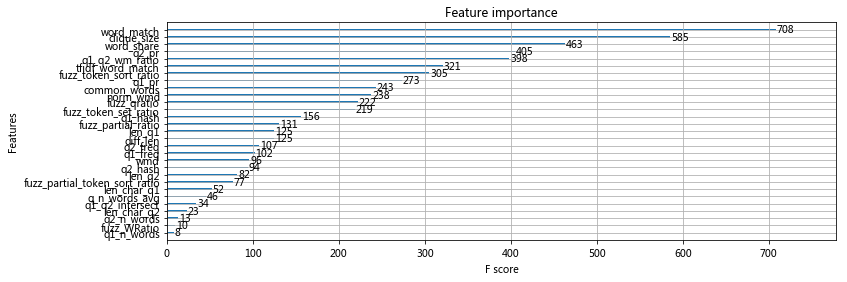

In [351]:
xgb.plot_importance(bst)

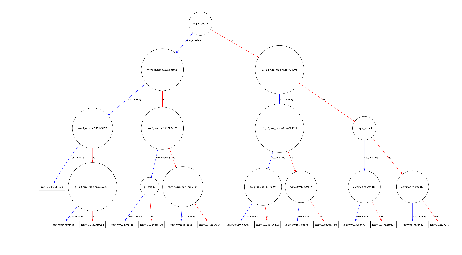

In [360]:
from graphviz import Digraph
xgb.plot_tree(bst, num_trees=2)

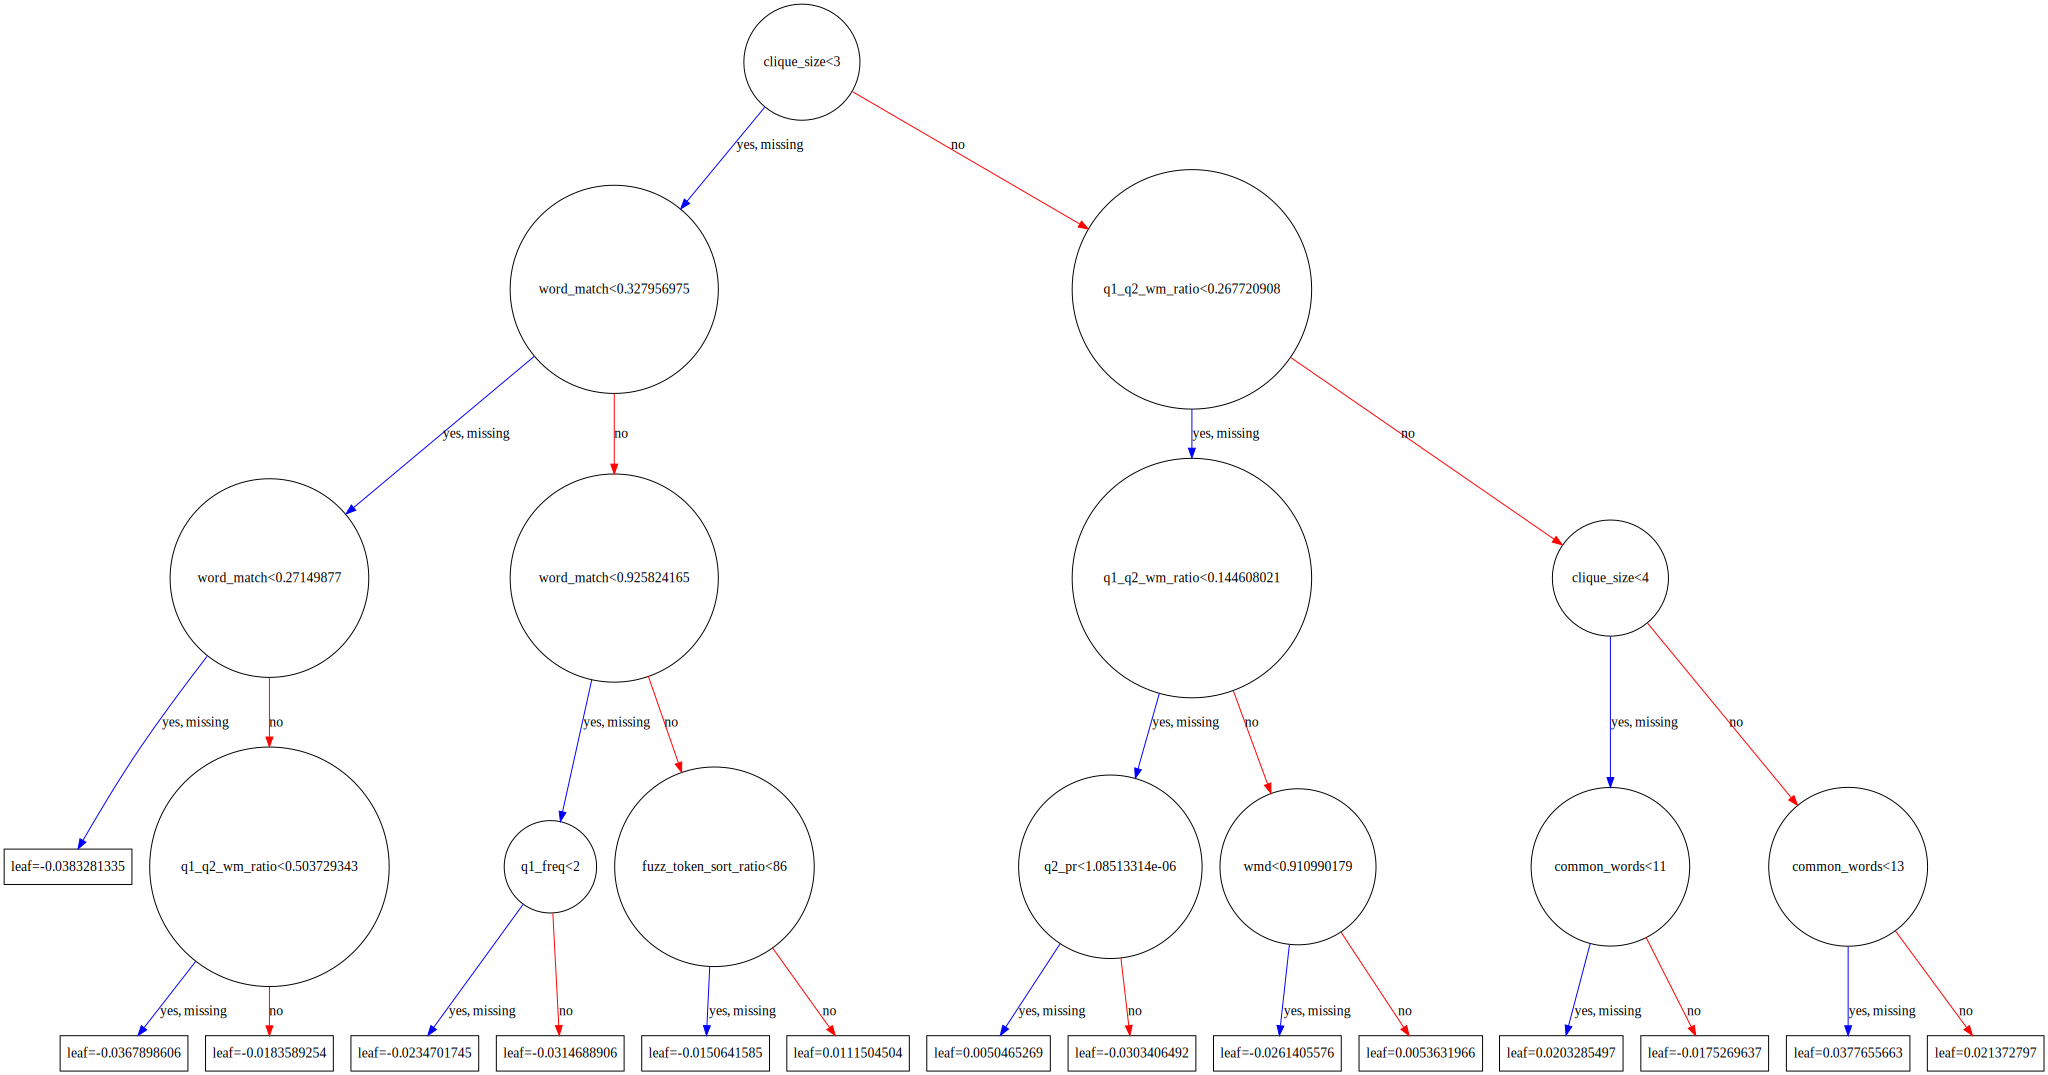

In [358]:
from graphviz import Digraph
xgb.to_graphviz(bst, num_trees=2)

In [371]:
graph = xgb.to_graphviz(bst, num_trees=2)

graph.render('./round-table.gv', view=True)

'./round-table.gv.pdf'